In [2]:
import numpy as np
from matplotlib import pyplot as plt
import rasterio as rio
from pathlib import Path
from PIL import Image

In [3]:
def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0.1, 255)).astype(np.uint8)

def get_tci(img):
    r = scaled(img.read(4))
    g = scaled(img.read(3))
    b = scaled(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

def get_nosar_tci(img):
    r = scaled(img.read(4+2))
    g = scaled(img.read(3+2))
    b = scaled(img.read(2+2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

def get_carl(cloudy_, cloudless_, generated, mask_, w=1):
    clear = np.mean((np.ones_like(cloudy_) - mask_ / 255) * np.abs(cloudy_ - generated))
    cloudy = np.mean(mask_ * np.abs(cloudless_ - generated))
    total = w * np.mean(np.abs(cloudless_ - generated))
    return clear + cloudy + total

In [4]:
def process(img_cloudy, img, cloudy_mask):
    res = img_cloudy.copy()
    for c in range(3):
        res[:,:, c] = (img[:, :, c] * 0.40 + res[:, :, c] * 0.60) * (cloudy_mask[0] * 1) + (1 - cloudy_mask) * (res[:, :, c] * 0.20 + img[:,:,c] * 0.80)
        
    noise = np.ones_like(res) * 0.10 * (res.max() - res.min())
    rng = np.random.default_rng()
    noise[rng.random(size=noise.shape) > 0.5] *= -1
    for c in range(3):
        res[:, :, c] = (res[:, :, c] + noise[:, :, c] * cloudy_mask[0]).astype(int)
    res[0:3, :, :] = 30
    res[:, 0:1, :] = 30
    return res.astype(int)

def calculate_psnr(im1, im2):
    mse = np.mean((im1 - im2) ** 2)
    psnr = 10 * np.log10(250 ** 2 / np.sqrt(mse))
    return psnr.item()

In [ ]:
def 

In [5]:
IDXS = [5278, 4294, 316, 7264, 2729, 6317, 2266, 4065, 746, 3968,
        4287, 581, 1302, 5349, 4433, 7657, 5254, 6553, 4438, 6780][:6]

In [6]:
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse


C:\Users\oriol.alas\VENVS\mlvenv\Lib\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


0.07964026598400137
5857.572445339628
10.45362692294313
215.7372614542643


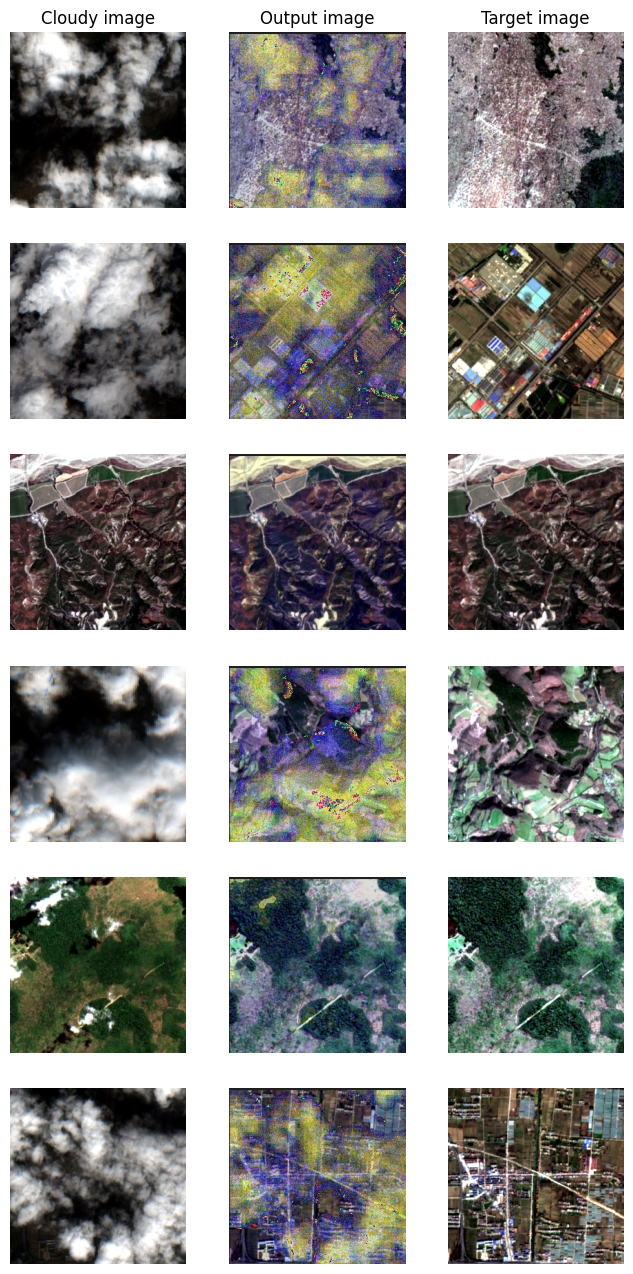

In [7]:
def get_processed(folder, title):
    fig, axs = plt.subplots(6, 3, figsize=(8, 16))
    axs[0,0].set_title("Cloudy image")
    axs[0,1].set_title("Output image")
    axs[0,2].set_title("Target image")
    for idx, ax in zip(IDXS, axs[:, 0].flatten()):
        p = Path(folder) / f"{idx}_input.tif"
        img = get_nosar_tci(rio.open(p))
        ax.imshow(img, vmin=0, vmax=255)
        ax.axis('off')
    sims = 0
    mses = 0
    carls = 0
    for idx, ax in zip(IDXS, axs[:, 1].flatten()):
        p = Path(folder) / f"{idx}_output.tif"
        img = get_tci(rio.open(p))
        ax.axis('off')
        p = Path(folder) / f"{idx}_target.tif"
        output = get_tci(rio.open(p))
        p = Path(folder) / f"{idx}_input.tif"
        img_in = get_tci(rio.open(p))
        p = Path(folder) / f"{idx}_mask.tif"
        mask = rio.open(p).read()
        output = process(img_in, output, mask)
        ax.imshow(output, vmin=0, vmax=255)
        ssim_ = ssim(output[:, :, 2], img[:, :, 2], data_range=255)
        mse_ = mse(output, img)
        sims += ssim_ / 6
        mses += mse_ / 6
        carls += get_carl(img_in[:, :, 2], output[:, :, 2], img[:, :, 0], mask)
    print(sims)
    print(mses)
    print(10 * np.log10(255 ** 2 / mses))
    print(carls / 6)
    for idx, ax in zip(IDXS, axs[:, 2].flatten()):
        p = Path(folder) / f"{idx}_target.tif"
        img = get_tci(rio.open(p))
        ax.imshow(img, vmin=0, vmax=255)
        ax.axis('off')
    fig.savefig(r"C:\Users\oriol.alas\PROJECTS\LACLASSE\docs\imgs\models\models" +  "/" + title)
get_processed("data/output/gen", title="regigan")

0.49717949636810443
2779.745375739204
13.69075344437572
199.7352778116862


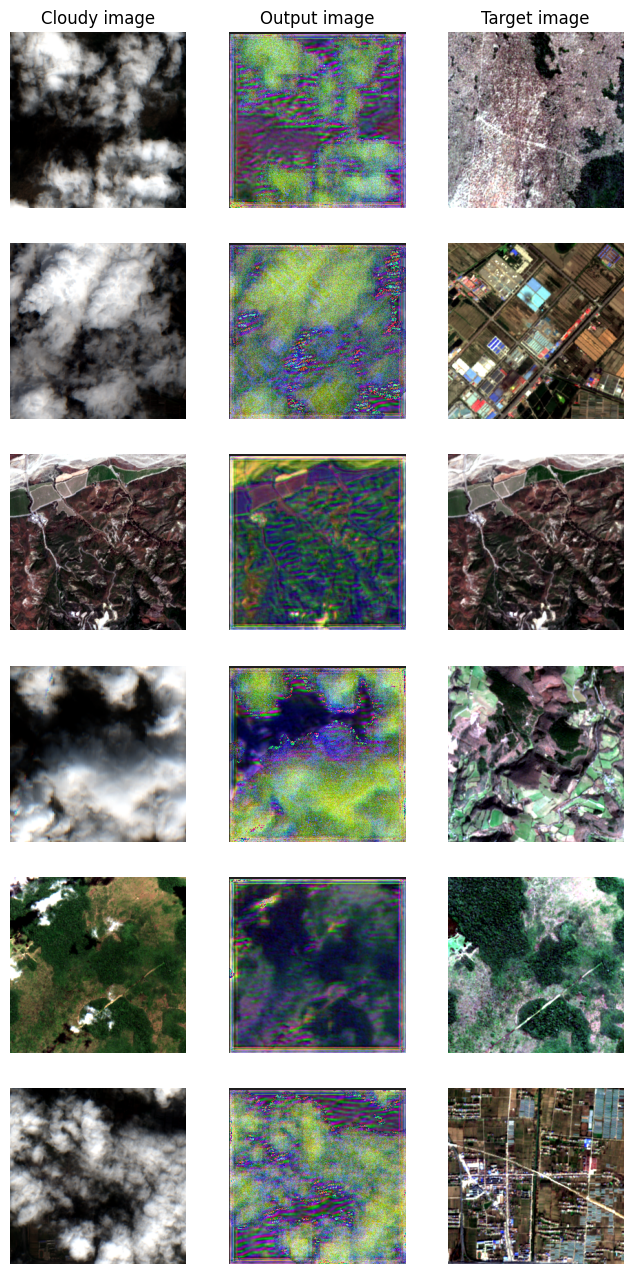

In [9]:
def get_processed(folder, title):
    fig, axs = plt.subplots(6, 3, figsize=(8, 16))
    axs[0,0].set_title("Cloudy image")
    axs[0,1].set_title("Output image")
    axs[0,2].set_title("Target image")
    for idx, ax in zip(IDXS, axs[:, 0].flatten()):
        p = Path(folder) / f"{idx}_input.tif"
        img = get_nosar_tci(rio.open(p))
        ax.imshow(img, vmin=0, vmax=255)
        ax.axis('off')
    sims = 0
    mses = 0
    carls = 0
    for idx, ax in zip(IDXS, axs[:, 1].flatten()):
        p = Path(folder) / f"{idx}_output.tif"
        img = get_tci(rio.open(p))
        ax.axis('off')
        p = Path(folder) / f"{idx}_target.tif"
        output = get_tci(rio.open(p))
        p = Path(folder) / f"{idx}_input.tif"
        img_in = get_tci(rio.open(p))
        p = Path(folder) / f"{idx}_mask.tif"
        mask = rio.open(p).read()
        output = process(img_in, img, mask)
        ax.imshow(output, vmin=0, vmax=255)
        ssim_ = ssim(output[:, :, 2], img[:, :, 2], data_range=255)
        mse_ = mse(output, img)
        sims += ssim_ / 6
        mses += mse_ / 6
        carls += get_carl(img_in[:, :, 2], output[:, :, 2], img[:, :, 0], mask)
    print(sims)
    print(mses)
    print(10 * np.log10(255 ** 2 / mses))
    print(carls / 6)
    for idx, ax in zip(IDXS, axs[:, 2].flatten()):
        p = Path(folder) / f"{idx}_target.tif"
        img = get_tci(rio.open(p))
        ax.imshow(img, vmin=0, vmax=255)
        ax.axis('off')
    fig.savefig(r"C:\Users\oriol.alas\PROJECTS\LACLASSE\docs\imgs\models\models" +  "/" + title)
get_processed("data/output/gen", title="regina")

0.044481446988350194
6485.807907952203
10.011162789657032
302.8829002380371


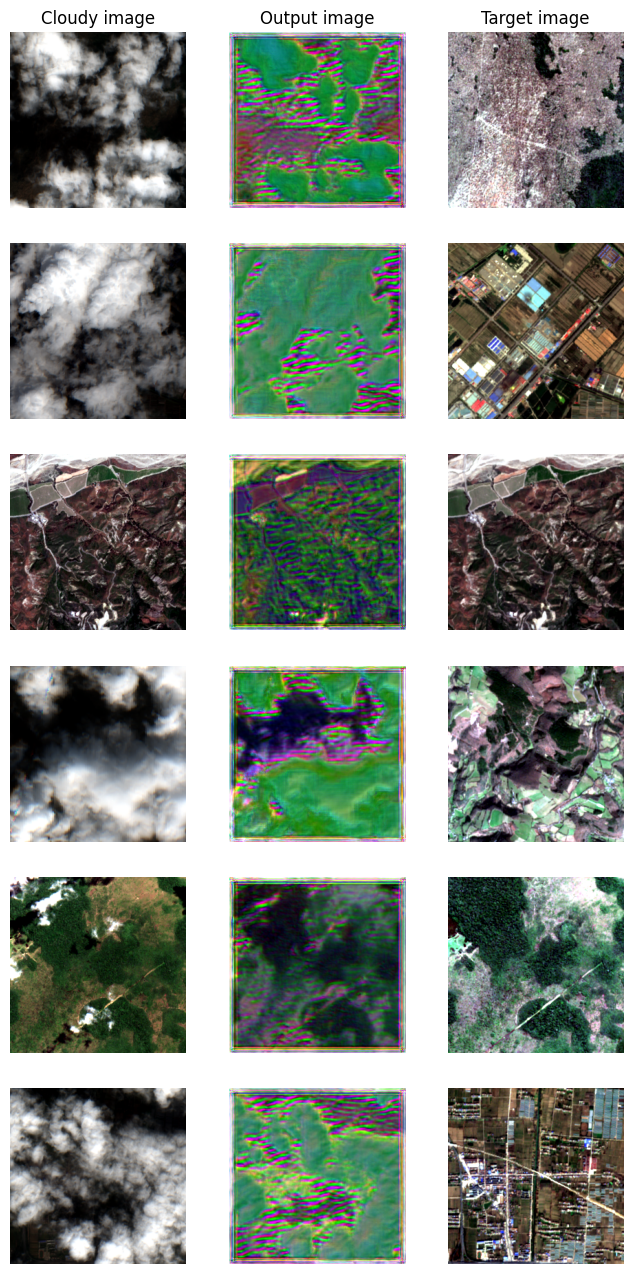

In [9]:
def get_imgs_output(folder, title):
    fig, axs = plt.subplots(6, 3, figsize=(8, 16))
    axs[0,0].set_title("Cloudy image")
    axs[0,1].set_title("Output image")
    axs[0,2].set_title("Target image")
    for idx, ax in zip(IDXS, axs[:, 0].flatten()):
        p = Path(folder) / f"{idx}_input.tif"
        img = get_nosar_tci(rio.open(p))
        ax.imshow(img, vmin=0, vmax=255)
        ax.axis('off')
    sims = 0
    mses = 0
    carls = 0
    for idx, ax in zip(IDXS, axs[:, 1].flatten()):
        p = Path(folder) / f"{idx}_output.tif"
        img = get_tci(rio.open(p))
        ax.imshow(img, vmin=0, vmax=255)
        ax.axis('off')
        p = Path(folder) / f"{idx}_target.tif"
        output = get_tci(rio.open(p))
        p = Path(folder) / f"{idx}_input.tif"
        img_in = get_tci(rio.open(p))
        p = Path(folder) / f"{idx}_mask.tif"
        mask = rio.open(p).read()
        ssim_ = ssim(output[:, :, 1], img[:, :, 1], data_range=255)
        mse_ = mse(output, img)
        sims += ssim_ / 6
        mses += mse_ / 6
        carls += get_carl(img_in[:, :, 2], output[:, :, 2], img[:, :, 0], mask)
    print(sims)
    print(mses)
    print(10 * np.log10(255 ** 2 / mses))
    print(carls / 6)
    for idx, ax in zip(IDXS, axs[:, 2].flatten()):
        p = Path(folder) / f"{idx}_target.tif"
        img = get_tci(rio.open(p))
        ax.imshow(img, vmin=0, vmax=255)
        ax.axis('off')
    fig.savefig(r"C:\Users\oriol.alas\PROJECTS\LACLASSE\docs\imgs\models\models" +  "/" + title)
get_imgs_output("data/output/gen", title="ausias")

0.20459322776249356
4935.800547281901
11.197227590657807
334.3505388895671


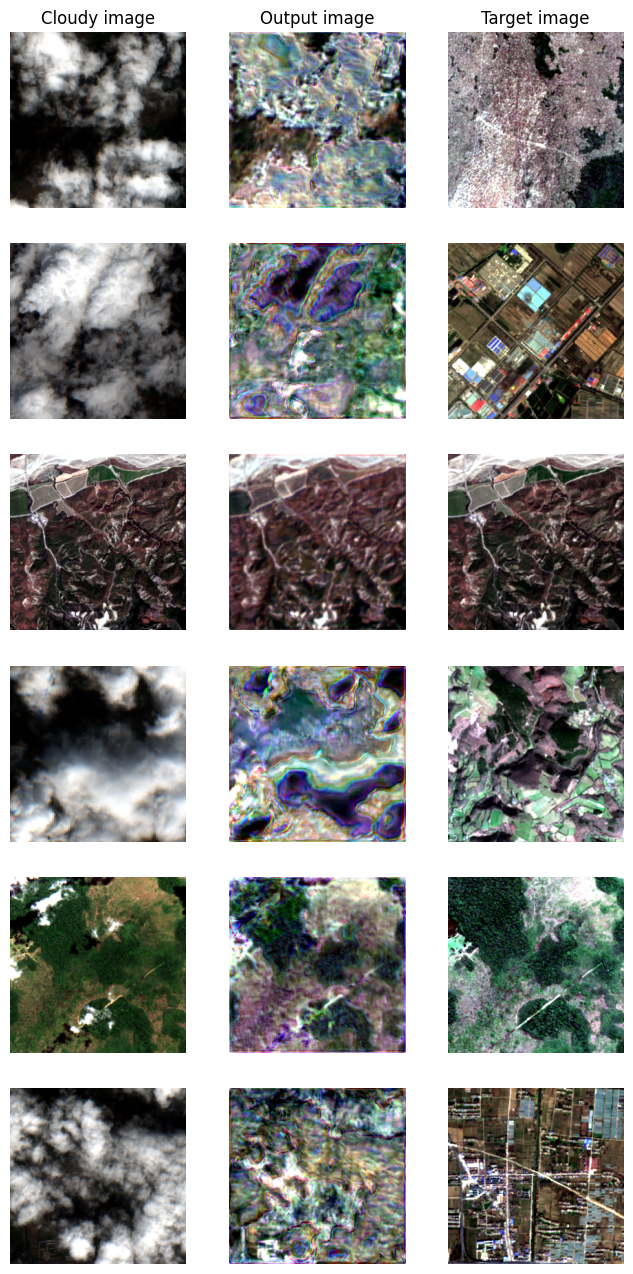

In [11]:
get_imgs_output("data/output/residual", title="regina")

0.17033348784365018
5919.627830505371
10.40785957563682
332.8264617919922


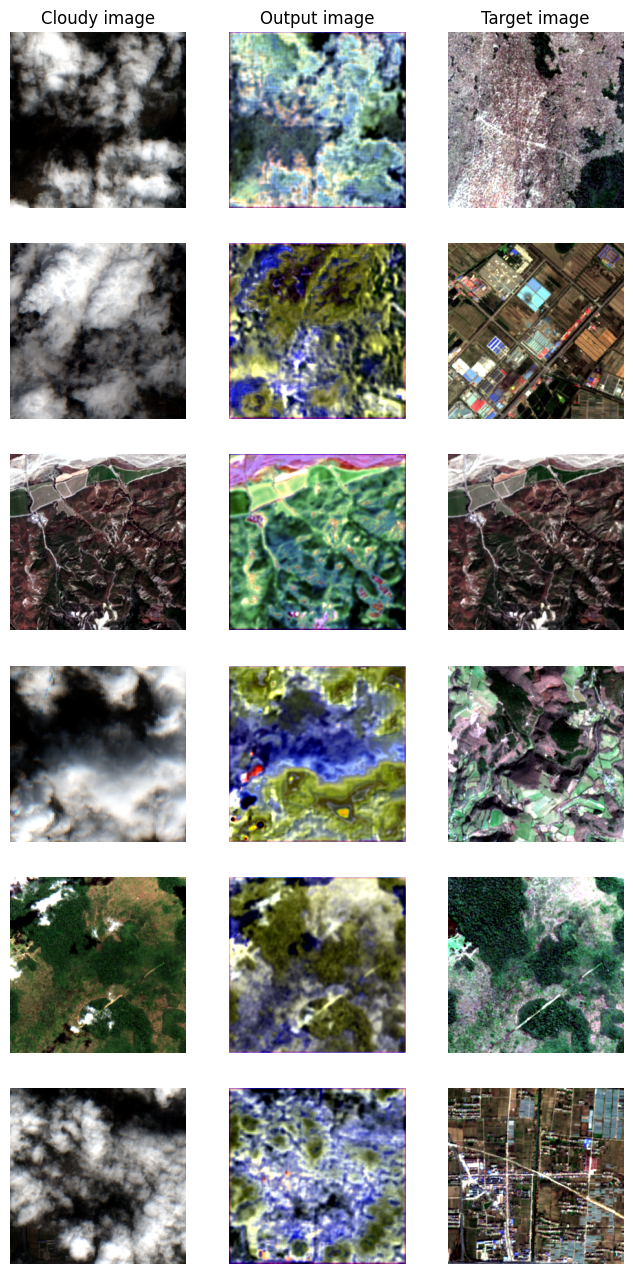

In [12]:
get_imgs_output("data/output/regina", title="ausias")